#### **Ideas for LLM'ing and increasing difficulty**
- Make chord progression/melody required (make sure they understand both horizontal and vertical mixing)
- Pick a filter of your choice (from Audacity?), implement it with LLM, and explain what/where it's happening (this will likely leverage scipy)
- Remove flipflop starter code? (i.e. only changeSpeed as example)



# Week 3 Lab: *Sounds Good!*
#### [35 pts; individual or pair; filename: hw3pr1.ipynb]

### **Step 0: Connect to Drive**
Follow all of the pop-up windows and connect it to your school account. 


This allows us to grab the audio files we need.



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [1]:
#@title **Step 1: Imports**
#@markdown Next we have to import the libraries and code used for this lab :)



# LIBRARY IMPORTS
#__________________________________________________________________________________________

import sys
import math
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display

sys.path.insert(1, '/content/gdrive/Shared drives/CS5_Test/hw3pr1_files')

import wave
wave.big_endian = 0




# CODE DEFINTIONS
#__________________________________________________________________________________________

def printParams(params):
    print('Parameters:')
    print('  nchannels:', params[0])
    print('  sampwidth:', params[1])
    print('  framerate:', params[2])
    print('  nframes  :', params[3])
    print('  comptype :', params[4])
    print('  compname :', params[5])

def tr(params, rf):
    """tr transforms raw frames to floating-point samples"""
    samps = [x for x in rf]    # convert to numeric bytes
    # give parameters nicer names
    nchannels = params[0]
    sampwidth = params[1]
    nsamples  = params[3]
    if sampwidth == 1:

        for i in range(nsamples):
            if samps[i] < 128:
                samps[i] *= 256.0       # Convert to 16-bit range, floating
            else:
                samps[i] = (samps[i] - 256) * 256.0

    elif sampwidth == 2:
        newsamps = nsamples * nchannels * [0]
        for i in range(nsamples * nchannels):
            # The wav package gives us the data in native
            # "endian-ness".  The clever indexing with wave.big_endian
            # makes sure we unpack in the proper byte order.
            sampval = samps[2*i + 1 - wave.big_endian] * 256 + samps[2*i + wave.big_endian]
            if sampval >= 32768:
                sampval -= 65536
            newsamps[i] = float(sampval)
        samps = newsamps
    else:
        print('A sample width of', params[1], 'is not supported.')
        print('Returning silence.')
        samps = nsamples * [0.0]

    if nchannels == 2:
        # Mix to mono
        newsamps = nsamples * [0]
        for i in range(nsamples):
            newsamps[i] = (samps[2 * i] + samps[2 * i + 1]) / 2.0
        samps = newsamps
    return samps

def tri(params, samps):
    """tri is tr inverse, i.e. from samples to rawframes"""
    if params[1] == 1:                 # one byte per sample
        samps = [int(x+127.5) for x in samps]
        #print 'max, min are', max(samps), min(samps)
        rf = [chr(x) for x in samps]
    elif params[1] == 2:               # two bytes per sample
        bytesamps = (2*params[3])*[0]  # start at all zeros
        for i in range(params[3]):
            # maybe another rounding strategy in the future?
            intval = int(samps[i])
            if intval >  32767:
                intval = 32767
            if intval < -32767:
                intval = -32767  # maybe could be -32768
            if intval < 0:
                intval += 65536 # Handle negative values
            # The wav package wants its data in native "endian-ness".
            # The clever indexing with wave.big_endian makes sure we
            # pack in the proper byte order.
            bytesamps[2*i + 1 - wave.big_endian] = intval // 256
            bytesamps[2*i + wave.big_endian] = intval % 256
        samps = bytesamps
        #print 'max, min are', max(samps), min(samps)
        rf = [chr(x).encode("latin-1") for x in samps]
    return b''.join(rf)

def get_data(filename):
    """The file needs to be in .wav format.
       There are lots of conversion programs online, however,
       that can create .wav from .mp3 and other formats.
    """
    # this will complain if the file isn't there!
    if filename == 'out.wav':
      fin = wave.open('/content/' + filename, 'rb')
    else:
      fin = wave.open('/content/gdrive/Shared drives/CS5_Test/hw3pr1_files/' + filename, 'rb')
    params = fin.getparams()
    #printParams(params)
    rawFrames = fin.readframes(params[3])
    # need to extract just one channel of sound data at the right width...
    fin.close()
    return params, rawFrames

def readwav(filename, printing = True):
    """readwav returns the audio data from the file
       named filename, which must be a .wav file.

       Call this function as follows:

       samps, sr = readwav(filename)

       samps will be a list of the raw sound samples (floats)
       sr will be the sampling rate for that list (integer)
    """
    sound_data = [0, 0]
    if printing:
      read_wav(filename, sound_data)
    else:
       read_wav(filename, sound_data, printing = False)
    samps = sound_data[0]
    sr = sound_data[1]
    if type(samps) != type([]): samps = [42] # default value
    return samps, sr

def read_wav(filename, sound_data, printing = True):
    """read_wav returns the audio data from the file
       named filename (the first input) in the list
       named sound_data (the second input)

       If the file exists and is the correct .wav format,
       then after this call sound_data will be a list of two
       elements:

       sound_data[0] will be a list of the raw sound samples
       sound_data[1] will be the sampling rate for that list

       That is, sound_data will be the following:

           [[d0, d1, d2, ...], samplingrate]

       where each d0, d1, d2, ... is a floating-point value
       and sampling rate is an integer, representing the
       frequency with which audio samples were taken.

       No value is returned from this function!
    """
    if type(sound_data) != type([]):
        print("""
            read_wav was called with a second input,
            sound_data, that was _not_ of type list.

            That input needs to be a list, e.g., []
            """)
        return # nothing
    # sound_data is a list: we create/clear its first two elements
    if len(sound_data) < 1:
        sound_data.append(0)
    if len(sound_data) < 2:
        sound_data.append(0)
    # now it has at least two elements, and we reset them
    sound_data[0] = 42
    sound_data[1] = 42
    try:
        params, rf = get_data(filename)
        samps = tr(params, rf)
    except:
        print("There was a problem with the file", filename)
        print("You might check if it's here and of")
        print("the correct format (.wav) ... ")
        return # nothing

    numchannels = params[0]
    datawidth = params[1]
    framerate = params[2]
    numsamples = params[3]

    if printing:
      print()
      print('You opened', filename, 'which has')
      print('   ', numsamples, 'audio samples, taken at')
      print('   ', framerate, 'hertz (samples per second).')
      print()
    sound_data[0] = samps
    sound_data[1] = framerate
    return # nothing

def write_data(params=None, rawFrames=None, filename="out.wav"):
    """Write data out to .wav format"""

    fout = wave.open(filename, 'wb')
    if params:
        fout.setparams(params)
        if rawFrames:
            fout.writeframes(rawFrames)
        else:
            print('no frames')
    else:
        print('no params')
    fout.close()

def write_wav(sound_data, filename="out.wav", printing = True):
    """write_wav creates a .wav file whose contents are sound_data.
       sound_data is [audio data, srate] as a list.

       The second parameter is the output file name.
       If no name is specified, this parameter defaults to 'out.wav'.
    """
    # first, make the sampling rate an int...
    sound_data[1] = int(sound_data[1])

    # then do some other checking
    if type(sound_data) != type([]) or \
       len(sound_data) < 2 or \
       type(sound_data[0]) != type([]) or \
       type(sound_data[1]) != type(42):
        print("""
            write_wav was called with a first input,
            sound_data, that was _not_ an appropriate list.

            That input needs to be a list such that
            sound_data[0] are the raw sound samples and
            sound_data[1] is the sampling rate, e.g.,

                [[d0, d1, d2, ...], samplingrate]

            where each d0, d1, d2, ... is a floating-point value
            and sampling rate is an integer, representing the
            frequency with whi audio samples were taken.
            """)
        return # nothing
    # name the two components of sound_data
    data = sound_data[0]
    samplingrate = sound_data[1]
    # compose the file...
    framerate = int(samplingrate)
    if framerate < 0:
        framerate = -framerate
    if framerate < 1:
        framerate = 1
    # always 1 channel and 2 output bytes per sample
    params = [1, 2, framerate, len(data), "NONE", "No compression"]
    # convert to raw frames
    rawframesstring = tri(params, data)
    write_data(params, rawframesstring, filename)
    if printing:
      print()
      print('You have written the file', filename, 'which has')
      print('   ', len(data), 'audio samples, taken at')
      print('   ', samplingrate, 'hertz.')
      print()
    return # nothing


def play(filename, graph = False):
    """Use Colab's Display and Audio packages to play an audio file
    """
    if type(filename) != type(''):
        raise TypeError('filename must be a string')

    try:
      display(Audio('/content/' + filename, autoplay=True))
      if graph == True:
        plot_wave(filename)
    except:
      path = '/content/gdrive/Shared drives/CS5_Test/hw3pr1_files/' + filename
      display(Audio(path, autoplay=True))
      if graph == True:
        plot_wave(filename)


def plot_wave(filename1, filename2):
    """plot_wave plots up to two sound waves using matplotlib
       Arugments: filename1, the file of the first wave to be plotted
                  filename2, the file of the second wave to be plotted
      Result: returns nothing, but instead diplays the generated plot(s)!
    """
    if filename2 == None:                                  # if only one file to graph:
      fig = plt.figure(figsize = (6,3))                    # create empty plot
      samps, sr = readwav(filename1, printing = False)     # get the sound data
      x_samp_data = list(range(len(samps)))                # for the x-data, create a list of the number of each sample (i.e. [0,1,2,...,len(samps)])
      x_time_data = [samp/sr for samp in x_samp_data]      # divide each sample number by the sample rate to find the time each sample occurs at
      y_data = samps                                       # assign the sample values to the y-data
      plt.plot(x_time_data, y_data)                        # plot the data
      plt.yticks([-32768,-16384, 0, 16384, 32767])         # set the ticks on the y-axis
      plt.xlim(0,len(samps)/sr)                            # set the limits of the x-axis to be 0 and the time of the final sample
      plt.ylim(-36000,36000)                               # set the limits of the y-axis to be a little about the min and max values of y
      plt.title("Sound Wave")                              # Set the graph title
      plt.xlabel("Time (s)")                               # Set the x-axis label
      plt.ylabel("Amplitude")                              # set the y-axis label
      plt.show()                                           # show the graph!
      return

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(6, 6))                # create 2 empty plots
    samps1, sr1 = readwav(filename1, printing = False)                        # get the sound data of the first sound
    samps2, sr2 = readwav(filename2, printing = False)                        # get the sound data of the second sound

    if len(samps1)/sr1 >= len(samps2)/sr2:                                    # this conditional finds the duration of the longer of the sounds
      x_samp_lim = len(samps1)                                                # which is used to give the graphs the same x-scale
      x_time_lim = len(samps1)/sr1
    else:
      x_samp_lim = len(samps2)
      x_time_lim = len(samps2)/sr2



    x1_samp_data = np.linspace(0,int(x_time_lim*sr1)+1,int(x_time_lim*sr1)+1) # number the samples from 0 to len(samps)
    x1_time_data = [samp_num/sr1 for samp_num in x1_samp_data]                # divide each sample number by the sample rate to find the time each sample occurs at

    y1_data = np.zeros((int(x_time_lim*sr1)+1,), dtype=int)                   # intially set all of the y data to 0
    for i in range(len(samps1)):                                              # for all of the samples we have, assign the y-data to be the sample values
      y1_data[i] = samps1[i]


    axes[0].plot(x1_time_data, y1_data)                                       # same plotting process as the one-sound case
    axes[0].set_xlim(0,x_time_lim)
    axes[0].set_ylim(-36000,36000)
    axes[0].set_yticks([-32768,-16384, 0, 16384, 32767])
    axes[0].set_title("Sound Wave 1")
    axes[0].set_xlabel("Time (s)")
    axes[0].set_ylabel("Amplitude")

    x2_samp_data = list(range(len(samps2)))                                   # repeat plotting for second sound

    x2_samp_data = np.linspace(0,int(x_time_lim*sr2)+1,int(x_time_lim*sr2)+1)
    x2_time_data = [samp_num/sr2 for samp_num in x2_samp_data]

    y2_data = np.zeros((int(x_time_lim*sr2)+1,), dtype=int)
    for i in range(len(samps2)):
      y2_data[i] = samps2[i]

    axes[1].plot(x2_time_data, y2_data, c='#cc2323')
    axes[1].set_xlim(0,x_time_lim)
    axes[1].set_ylim(-36000,36000)
    axes[1].set_yticks([-32768,-16384, 0, 16384, 32767])
    axes[1].set_title("Sound Wave 2")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Amplitude")

    plt.tight_layout()                                                        # set the layout to prevent text and graphs from overlapping
    plt.show()                                                                # show the plot
    return


def test():
    """A test function that plays swfaith.wav
       You'll need swfaith.wav in this folder.
    """
    play('swfaith.wav')



# Now, try *playing* a sound file ...

At the bottom of the code import, there is a small function named `test()`. That function plays one of the sound files. \\


If all goes well, you should here Darth Vader. (*This is not always true in the Star Wars universe, but for our purposes: ok!*)

In [ ]:
test()

Next, you'll remind yourself about list comprehensions... .

# Using list comprehensions (*LC*$\,$s)

## **Task #0:** Run   *three_ize* ...
_____________________




Take a moment to remind yourself how *list comprehensions* work...

Look over the `three_ize` function in the cell below

In [ ]:
def three_ize(L):
    """three_ize is the motto of the green CS 5 alien.
       It's also a function that accepts a list and
       returns a list of elements, each three times as large.
    """
    # This is an example of a list comprehension
    LC = [3 * x for x in L]
    return LC

This function "maps" the expression `3 * x` over the values `x` in the list `L`

Try it out with \\
**Example(s):**

In [ ]:
three_ize([13, 14, 15])

[39, 42, 45]

Which should lead to this output below the cell:

`[39, 42, 45]`


 List comprehensions are a versatile syntax for mapping a function (or expression) across all elements of a list.

If you feel good about list comprehensions, onward! (If you think more explanation or practice would be worthwhile, try our [ListComprehension](https://www.cs.hmc.edu/twiki/bin/view/CS5/ListComprehension) page.)

## **Function to write #1:** `scale`
______________________


With the above function as your model, write a function `scale` with the following signature:

`def scale(L, scale_factor):`

where `scale` returns a list similar to `L`, except that each element has been multiplied by `scale_factor`.

\\

**Example(s):**

`scale([70, 80, 420], 0.1)`

Which will create the following output:

`[7.0, 8.0, 42.0]`

Use a list comprehension here.

In [ ]:
#write scale here!

## **Going further:** *index-based*  list comprehensions
_________________________


 Next, look over  this `three_ize_by_index` function.

In [ ]:
def three_ize_by_index(L):
    """three_ize_by_index has the same behavior as three_ize
       but it uses the INDEX of each element, instead of
       using the elements themselves--this is much more flexible!
    """
    # another example of a list comprehension
    N = len(L)
    LC = [3 * L[i] for i in range(N)]
    return LC

This function does *exactly the same thing* as `three_ize`—it simply uses the index of each element to do so. That is, now the ***location*** of each element, named `i`, is changing.

This index-based use of list comprehensions is even more flexible than the element-based style, as the next couple of questions will show.

## **Functions to write #2 and #3:** `add_2` and `add_3`

______________________________________


With the above ***index-based*** function as a guide, write a function add_2 with the following signature:

`def add_2(L, M):`

such that `add_2` accepts two lists and returns a single list that is an element-by-element sum of the two arguments. If the arguments are different lengths, your `add_2` should return a list that is as long as the shorter of the two. Just ignore or drop the extra elements from the longer list.

\\

Using `min` and `len(L)` and `len(M)1 together is one way to do this. For example, the line

```
N = min(len(L), len(M))    # N is the min length!
```

will assign the smaller of the lengths of `L` and `M` to `N`. Then, you can use `range(N)` instead of `range(len(L))`. Try it!

\\

You will want to use the *index-based* approach for this `add_2` function. You might use `three_ize_by_index` as a starting point. Also, consider how this `LC` might help:

```
LC = [L[i] + M[i] for ... ]
```


Here are two examples of `add_2` in action:

`add_2([10, 11, 12], [20, 25, 30])`

should return:

`[30, 36, 42]`

\\

`add_2([10, 11], [20, 25, 30])`

should return:

`[30, 36]`

In [ ]:
# write add_2 here!

 ________________________
 Then, write the analogous three-argument function, `add_3`, with the following signature:

`def add_3(L, M, P):`

where `L`, `M`, and `P` are all lists and `add_3` returns the sum of all of them, but with only as many elements as the shortest among them has.

\\
The strategy will be very similar to `add_2`.

In [ ]:
# write add_3 here!

## **Function to write #4:** `add_scale_2`
_________________


Next, write a function `add_scale_2` with the following signature:

`def add_scale_2(L, M, L_scale, M_scale):`

such that `add_scale_2` accepts two lists `L` and `M` and two floating-point numbers `L_scale` and `M_scale`. These stand for *scale for L* and *scale for M*, respectively.


Then, `add_scale_2` should return a single list that is an element-by-element sum of the two argument lists, *each scaled (multiplied) by its respective floating-point value*. If the argument lists are different lengths, your `add_scale_2` should return a list that is as long as the *shorter* of the two. Again, just drop any extra elements.

\\

**Example(s):**

`add_scale_2([10, 20, 30], [7, 8, 9], 0.1, 10)`

should return:

`[71.0, 82.0, 93.0]`

`add_scale_2([10, 20, 30], [7, 8], 0.1, 10)`

should return:

`[71.0, 82.0]`

This will not be too different from the previous examples!



In [ ]:
# write add_scale_2 here!

## **A helper function:** `randomize`


Next, take a look at this function...

In [ ]:
def randomize(x, chance_of_replacing):
    """Randomize accepts an original value, x
       and a fraction named chance_of_replacing.

       With a "chance_of_replacing" chance, it
       returns a random float from -32767 to 32767.

       Otherwise, it returns x (not replacing it).
    """
    r = random.uniform(0, 1)
    if r < chance_of_replacing:
        return random.uniform(-32768, 32767)
    else:
        return x

In [ ]:
randomize(42,0.5)

Read over the docstring and try it out.

There is nothing to do here except build an understanding of what this function is doing: how often it returns the original argument and how often it returns a random value. That random value happens to always be within the amplitude range of a sound's pressure samples.

Though it's random, here is a set of five real runs:

`randomize(42, .5)` \\
`42`

`randomize(42, .5)` \\
`42`

`randomize(42, .5)` \\
`29209.30669767395`

`randomize(42, .5)` \\
`42`

`randomize(42, .5)` \\
`17751.221299744262`


## **Function to write #5:** `replace_some`
_____________________


Next, write a function `replace_some` with the following signature:

`def replace_some(L, chance_of_replacing):`

such that `replace_some` accepts a list `L` and a floating-point value `chance_of_replacing`.

Then, `replace_some` should independently replace—or not replace—each element in `L`, using the helper function `randomize`.

Since this function is random, the runs below won't be replicated on your system, but try yours out to make sure it's working in a similar fashion.

\\

**Example(s):**

`replace_some(range(40, 50), .5)  # replace about half  (hopefully the 42 remains!)` \\
`[40, 41, 42, -17461.09350529409, 44, -13989.513742241645, 46, -26247.774200304026, 48, 49]`

\\

`replace_some(range(20, 30), .1)  # replace about a tenth  (but it's random: here 2 of them get replaced)` \\
`[20, 21, 16774.26240973895, 23, 24, 25, -18184.919872079583, 27, 28, 29]`

\\

To help you test, here are two assertions to paste into your cell. Note that second one says that the result is DIFFERENT from 42!

`assert replace_some(range(40, 50), 0) == list(range(40, 50))` \\
`assert replace_some([42], 1.0) != [42]`


In [ ]:
#@title Hint

#Use randomize in a list comprehension: that's it! Consider how to complete this thought (and don't forget to return LC):

LC = [randomize(______,________) for x in L]



 In addition to providing practice with data and functions, the above examples will be helpful in creating functions that handle audio data in various ways...

The `replace_some` function will allow you to add "static" (random values) to *part* of a sound, e.g., to make it sound "crackly."

# *Sound* coding...

First things first: you may wish to again try out this function, which should already be at the bottom of the code import for this notebook.

In [ ]:
test()

 ~For this to work, your Colab notebook will need to support sound (every version we've tested does). If yours does not—no problem, simply work with a partner from here on during this lab, or switch to one of the lab Macs.~

Also, you'll need the `swfaith.wav` file to be accessible through your shared Google Drive. This should be already done if the very first block of code ran succesfully. If not or if it still doesn't work, make sure that you can see the `[CS5 SHARED DRIVE NAME]` folder in your "Shared Drives" tab of Google Drive (separate from "Shared with me"). If you can't... [`fill in`]

\\

Before we go on, you'll need a bit of background information on audio data. Then you'll have a chance to write a number of audio-processing functions.

## Background on representing audio information
______________________

What is inside an audio file?

Depending on the format, the actual audio data might be encoded in many different ways. One of the most basic is known as pulse code modulation (PCM), in which the sound waves are sampled every so often and given values in the range -128 to 127 (if 1 byte per sound sample is used) or -32768 to 32767 (if there are 2 bytes for each sample). [Wikipedia explains it here.](https://en.wikipedia.org/wiki/Pulse-code_modulation)

The **.wav** file format encodes audio in basically this way, and the cross-platform program [Audacity](http://audacity.sourceforge.net/download/) is an excellent tool for visualizing the individual PCM samples of an audio file. You don't need Audacity for this problem, but it runs on Windows and Macs and is fun to play around with if you'd like to. Audacity can also convert to `.wav` from `.mp3` and many other formats. Last but not least, Audacity was created by Dominic Mazzoni, an HMC alum!

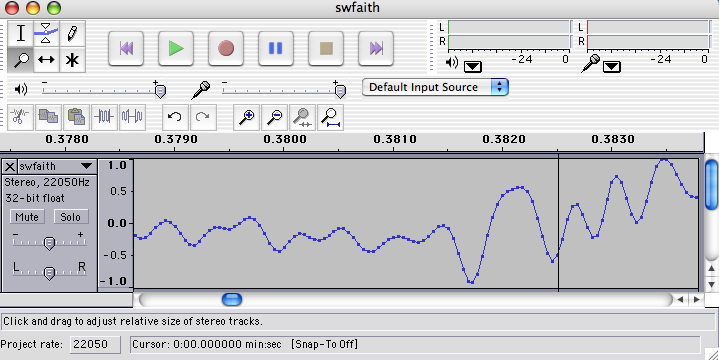

## Getting started with sound
__________________________

We present two examples to start acquiring and manipulating sound data. Try these:

### **Sound exmaple #1:** `changeSpeed`

In [ ]:
#
# Our first example: the changeSpeed function
#

def changeSpeed(filename, newsr, graph = False):
    """changeSpeed allows the user to change an audio file's speed.
       Arguments: filename, the name of the original file
                  newsr, the new sampling rate in samples per second
       Result: no return value, but
               this creates the sound file 'out.wav'
               and plays it
    """
    samps, sr = readwav(filename)   # get samps and sr from the file!

    print("Playing the original sound...")
    play(filename)
    print()

    print("The first 10 sound-pressure samples are\n", samps[:10])
    print("The number of samples per second is", sr, '\n')


    time.sleep(len(samps)/sr + 0.5) #wait until the first sound finishes playing before playing the altered one!


    # we don't really need this line, but for consistency...
    newsr = newsr             # from the input! (not needed, a reminder!)
    newsamps = samps          # same samples as before
    write_wav([newsamps, newsr], "out.wav") # write data to out.wav

    print("\nPlaying new sound...")
    play('out.wav')   # play the new file, 'out.wav'

    if graph == True:
        plot_wave(filename, 'out.wav') #plot both filename and the output file

Let's try it out!

In [ ]:
changeSpeed("swfaith.wav", 44100)

In [ ]:
changeSpeed("swfaith.wav", 44100, graph = True) #try graphing the waves too!

## *What's inside the sound-processing code?*


1. The sound data is returned ***in two pieces*** by the call to `read_wav`, using the line `samps, sr = read_wav(filename)`
  - `readwav` is returning two things:
    - `samps`, a list of each air-pressure sample in the sound (`samps` has a lot of elements!)
    - `sr`, an integer that is number-of-samples-to-play-per-second (usually `22050`)
2. To reiterate, the variable `samps` is a large list of raw pressure samples (floats). **Be careful about printing this list**—it can be too big and can slow down or completely choke the terminal. Perhaps print `samps[:10]` instead.
3. Also, after those lines, the variable `sr` is an integer that represents the *sampling rate*, i.e., the number of samples that should be played per second for normal-speed playback. It's usually `22050`.
4. Some printing happens, so that you can see information about these variables.
5. For consistency, we use the variable `newsamps` to label the new sound data samples. In this case they're not changing at all, but in some later programs `newsamps` will be different from `samps`.
6. Similarly, for consistency, we assign the new sampling rate with `newsr = newsr`. Again, this isn't really needed, but it's the same scaffolding for all our audio transformations.
7. The code then uses the line `write_wav([newsamps, newsr], "out.wav")` to write the new sound data, `newsamps` and `newsr`, which must be put in a list, out to a file named `out.wav`, which will be embedded into the output cell and saved in the cloud (click the "Files" tab on the left of Colab to see these files).
8. To finish, the function plays that new file, which is now at the sampling rate of `newsr`.


Variations of these steps will be in all of the sound functions.


The next example shows how to create a new sound by changing the samples themselves. That is, `newsamps` will be different from `samps` (the old samples). Remember that `samps` will be a very large list of pressure values (≈50,000 elements).


## **Sound example #2:** `flipflop`

In [ ]:
#
# Our second example: the flipflop function
#
def flipflop(filename, graph = False):
    """flipflop swaps the halves of an audio file
       Arguments: filename, the name of the original file
                 graph, whether or not the sound wave should be plotted
       Result: no return value, but
               this creates the sound file 'out.wav'
               and plays it
    """

    samps, sr = readwav(filename)   # get samps and sr from the file!

    print("Playing the original sound...")
    play(filename)
    print()


    print("The first 10 sound-pressure samples are\n", samps[:10])
    print("The number of samples per second is", sr)
    print()
    print()

    time.sleep(len(samps)/sr + 0.5) #wait until the first sound finishes playing before playing the altered one!

    print("Computing new sound...")
    # this gets the midpoint and calls it x
    x = len(samps)//2
    newsamps = samps[x:] + samps[:x]
    newsr = sr               # same sr as before

    write_wav([newsamps, newsr], "out.wav") # write data to out.wav
    print("\nPlaying new sound...")
    play('out.wav')   # play the new file, 'out.wav'

    if graph == True:
        plot_wave(filename, "out.wav") #plot both filename and the output file

Let's try this one out!

In [ ]:
flipflop("spam.wav")  # or "swfaith.wav" or "swnotry.wav"

In [ ]:
flipflop("spam.wav", graph = True)  # graph!

 Take a look back at the middle part of this code, where the new sound samples are created from the old ones. In this case, the `newsamps` are a "flipflopped" version of the old `samps`. You may recognize this code as exactly the same as the `flipside` problem from Lab 2[`\link`].

As a result, the sound's second half is placed before its first half.


In building your audio-processing functions, use `flipflop` as a starting point; ***copy-and-paste-and-alter*** from `flipflop` is a great approach!

## **Sound function to write #1:** `reverse`
________________________

Next, write a sound-handling function `reverse` with the following signature:

`def reverse(filename):`

such that `reverse` accepts a `filename` as did `flipflop`.

\\

Copy-and-paste `flipflop` to get started!

Like flipflop, the sampling rate should not change, but the function should create a reversed set of sound samples and then handle them in the same way as the two examples above. That is, you'll want to write them to the file out.wav and then play that file.



***Remember*** that to reverse the list **`samps`**, you can write **`samps[::-1]`** in Python!


\\

**Example(s):**

`reverse('swfaith.wav')  # redaV htraD sounds eerier but less intimidating` \\
`... lots of printing ...`

Note that this `reverse` function ***won't need*** to use any of the helper functions you wrote above—but the next few will!

In [ ]:
# write reverse here!

## **Sound function to write #2:** `volume`
_________________________

Now, write a sound-handling function `volume` with the following signature:

`def volume(filename, scale_factor):`

such that `volume` accepts a `filename` as usual and a floating-point value `scale_factor`.

Then, `volume` should handle the sound in the usual way, with the output file and played sound being scaled in amplitude (volume) by the scaling factor `scale_factor`. In other words, each sample should be multiplied by `scale_factor`.

In [ ]:
#@title Hint

#Here, use the helper function "scale" you wrote at the beginning of the lab!

#All you'll need is
newsamps = scale(________ , __________)


#(This is quite typical—only a very small amount of the sound code needs to be altered for each function.)


**Example(s):**

`volume('swfaith.wav', .1)  # A calmer Darth...` \\
`... lots of printing ...`

`volume('swfaith.wav', 10.0)  # A caffeinated Darth!` \\
`... lots of printing ...`

You'll notice that your hearing adjusts remarkably well to this function's changes in absolute volume, making the perceived effect less than you might expect.

You will also find that if you *increase* the volume too much, the sound becomes distorted, just as when an amplifier is turned up to [11](https://youtu.be/hW008FcKr3Q).

In [ ]:
# write volume here!

## **Sound function to write #3:** `static`
________________________

Now, write a sound-handling function `static` with the following signature:

`def static(filename, probability_of_static):`

such that `static` accepts a `filename` (as usual) and a floating-point value `probability_of_static`, which you can assume will be between 0 and 1.

Then, `static` should handle the sound in the usual way, with the output samples being replaced with a probability of `probability_of_static`. When they're replaced, the samples should simply be random values, uniformly chosen in the valid range from -32768 to 32767.

Here, you should use the helper function `replace_some` that you wrote earlier in the lab. You won't need `randomize`, because `replace_some` already uses it!

\\


**Example(s):**

`static('swfaith.wav', .05)  # Vader, driving into a tunnel` \\
`... lots of printing ...`

`static('swfaith.wav', .25)  # Vader on dial-up from a galaxy far, far away` \\
`... lots of printing ...`

You might see how high you can increase the percentage of static until the original is no longer discernible. People adapt less well to this than to volume changes.

In [ ]:
# write static here!

## **Sound function to write #4:** `overlay`
__________________________

Now, write a sound-handling function `overlay` with the following signature:

`def overlay(filename1, filename2):`

such that `overlay` accepts two `filenames`, and creates a new sound that overlays (combines) the two. The result should be as long as the shorter of the two. (Drop any extra samples, just as in `add_scale_2`.)

Use your `add_scale_2` helper function to assist with this! That way, you can adjust the relative loudness of the two input files. You are welcome, but certainly not required, to add more arguments to your `overlay` function so that you can change the relative volumes on the fly (or crop the sounds on the fly, which is a bit more ambitious).

***Remember*** that `add_scale_2(samps1, samps2, 0.5, 0.5)` ***must*** take lists (`samps`) as arguments—not filenames, which are simply strings! The `samps` are lists of the raw sound data.

\\

**Example(s):**

`overlay('swfaith.wav', 'swnotry.wav')  # Vader vs. Yoda` \\
`... lots of printing ...`

\\

Extra: how could you modify `overlay` so that it doesn't truncate the longer sound? Instead of truncating it, you could let it continue against silence, or you could repeat the shorter sound...


The next function overlays a file with a shifted version of itself.

In [ ]:
#write overlay here!

## **Sound function to write #5:** `echo`
____________________________________

This one is more of a challenge... .

Try writing a sound-handling function `echo` with the following signature:

`def echo(filename, time_delay):`

such that `echo` accepts a `filename` as usual and a floating-point value `time_delay`, which represents a number of seconds.

Then, `echo` should handle the sound in the usual way, with the original sound being overlaid by a copy of itself shifted later in time by `time_delay`.

To do the overlaying, you'll want to use `add_scale_2`, as before.

To handle the time-shifting, notice that you can use the sampling rate to convert between the number of samples and time in seconds:

- For example, if `time_delay` is `0.1` and the sampling rate is `22050`, then the number of samples to wait is `2205`
- Similarly, if `time_delay` is `0.25` and the sampling rate is `44100`, then the number of samples to wait is `11025`

In [ ]:
#@title Hint

#How to "add wait time" to samples:
#The easiest way to add "blank space" or "blank sound" in front of 'samps' is to concatenate (add a list of)
# zeros to the front of the list 'samps'.


#For example,
samps2 = [0]*42 + samps
#would "wait" 42 samples, by including 42 blank-sound samples, at the start of the sound data 'samps'.

#You'll probably want a value *other* than 42—in fact, the challenge is to compute the correct value there!

#How could you figure out what integer you need *instead* of 42?
    # - Remember that you know the time you'd like (in seconds) and the sampling rate (in samples per second).
    # - Be sure that you use an integer—remember that, if you have a floating-point value 'f', then 'int(f)' is an integer.
    # - There are other approaches, too. For example, if you want the "echo portion" not to be clipped,
    #   try adding the _same_ number of '0'-samples to the *right* side of the original 'samps'! (With thanks to Arya M. '24 on this!)


**Example(s):**

`echo('swfaith.wav', .1)  # How many zeros would be needed in front?` \\
`... lots of printing ...`


## **Sound example #3:** generating pure tones
________________________

The final provided example functions generate a pure sine-wave tone. Here is the code.

In [9]:
# Helper function for generating pure tones
def gen_pure_tone(freq, seconds):
    """pure_tone returns the y-values of a cosine wave
       whose frequency is freq Hertz.
       It returns nsamples values, taken once every 1/44100 of a second.
       Thus, the sampling rate is 44100 hertz.
       0.5 second (22050 samples) is probably enough.
    """
    # we get to pick our own sampling rate, sr
    sr = 22050
    # how many data samples to create
    nsamples = int(seconds*sr) # rounds down
    # our frequency-scaling coefficient, f
    f = 2*math.pi/sr   # converts from samples to Hz
    # our amplitude-scaling coefficient, a
    a = 32767.0

    # now, create the sound!
    samps = [a*math.sin(f*n*freq) for n in range(nsamples)]
    sr = sr   # not needed, but a reminder
    return [samps,sr]



def pure_tone(freq, time_in_seconds):
    """Generates and plays a pure tone of the given frequence."""
    print("Generating tone...")
    samps, sr = gen_pure_tone(freq, time_in_seconds)

    print("The first 10 sound-pressure samples are\n", samps[:10])
    print("The number of samples per second is", sr)

    print("Writing out the sound data...")
    write_wav([samps, sr], "out.wav") # write data to out.wav

    print("Playing new sound...")
    play('out.wav')

In [13]:
pure_tone(440, 2)

Generating tone...
The first 10 sound-pressure samples are
 [0.0, 4097.530509898602, 8130.73286357246, 12036.2888086092, 15752.884045488694, 19222.170816105277, 22389.683919814433, 25205.69577623888, 27625.997110989283, 29612.591008119147]
The number of samples per second is 22050
Writing out the sound data...

You have written the file out.wav which has
    44100 audio samples, taken at
    22050 hertz.

Playing new sound...


 Look over this code and try it out to get a feel for what it does, though the math of the sine wave is not crucial.

Rather, the important details are that the function `pure_tone` takes a desired frequency `freq` and the span `time_in_seconds`. The mathematical details are then delegated to `gen_pure_tone`.

\\

**Example(s):**

`pure_tone(440, 0.5)  # 0.5 seconds of the concert-tuning A` \\
`... lots of printing ...`

You can look up frequencies for other notes [at this Wikipedia page](http://en.wikipedia.org/wiki/Piano_key_frequencies), among many others. Here's a small chart, as well:

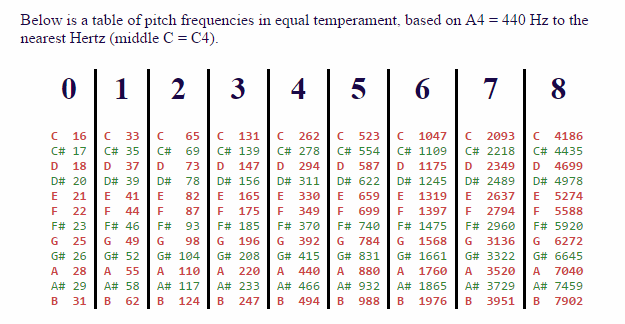

It's interesting to note that C0 is below the range of normal human hearing (we can only heard down to about 20 Hz) but B8 leaves plenty of room (most people below the age of 40 can hear to 20,000 Hz or higher). Also, most pianos only go to A0 (28 Hz), but the Bösendorfer Imperial Concert Grand has extra keys (colored black) that go all the way down to C0. Just in case you need extra bass!

## **Sound function to write #6:** `chord`
________________________________

The final lab problem is to build on the above example to write a chord-creation function named `chord`, with the following signature:

`def chord(f1, f2, f3, time_in_seconds):`

such that `chord` accepts three floating-point frequencies `f1`, `f2`, and `f3`, along with a floating-point `time_in_seconds`.

In the end, your `chord` function should create and play a three-note chord from those frequencies.

You will want to get ***three*** sets of `samps` and `sr` from `gen_pure_tone`, e.g.,

```
samps1, sr1 = gen_pure_tone(f1, time_in_seconds)
samps2, sr2 = gen_pure_tone(f2, time_in_seconds)
samps3, sr3 = gen_pure_tone(f3, time_in_seconds)
```

**Then**, you really need an `add_scale_3` function, though we don't have that yet. But you can create it! (You could use `add_scale2` and `add_3` as starting points, but we'd recommend writing `add_scale_3` on its own—not calling those other functions.)


Finally, you'll need to take the resulting samples-list (perhaps name it `newsamps`) and process it using code borrowed from the previous functions:
```
    new_sound_data = [newsamps, newsr]

    print("Writing out the new sound data...")
    write_wav(new_sound_data, "out.wav") # write data to out.wav

    print("Playing new sound...")
    return play('out.wav')
```

**Example(s):**

`chord(440.000, 523.251, 659.255, 1.0)   # A minor chord` \\
`... lots of printing ...`



In [48]:
#write chord here!

import math

def gen_chord(freqs, duration):
    """Generate a chord with the given frequencies and duration."""
    sr = 22050  # Sampling rate
    nsamples = int(duration * sr)  # Number of samples
    f = 2 * math.pi / sr  # Frequency scaling coefficient
    a = 32767.0  # Amplitude scaling coefficient

    # Generate samples for each frequency
    tones = []
    for freq in freqs:
        tone_samples = [a * math.sin(f * n * freq) for n in range(nsamples)]
        tones.append(tone_samples)

    # Combine samples of all frequencies without distortion
    chord_samples = [0] * nsamples
    for tone in tones:
        for i, sample in enumerate(tone):
            chord_samples[i] += sample / len(freqs)

    return chord_samples, sr

def export_chord(freqs, duration, filename="chord.wav"):
    """Generate a chord with the given frequencies and duration,
    then export it to a WAV file."""
    chord_samples, sr = gen_chord(freqs, duration)
    write_wav([chord_samples, sr], filename)
    print("Chord exported to", filename)


You have written the file chord.wav which has
    22050 audio samples, taken at
    22050 hertz.

Chord exported to chord.wav


In [43]:
play('chord.wav')

In [50]:
def chord(chord_name):
    """Get frequencies of a chord in 12-TET given the chord name."""
    # Define mapping from note names to frequencies (A4 = 440 Hz)
    root_note_mapping = {'C': 261.63, 'C#': 277.18, 'Db': 277.18, 'D': 293.66, 'D#': 311.13, 'Eb': 311.13,
                         'E': 329.63, 'F': 349.23, 'F#': 369.99, 'Gb': 369.99, 'G': 392.00, 'G#': 415.30,
                         'Ab': 415.30, 'A': 440.00, 'A#': 466.16, 'Bb': 466.16, 'B': 493.88}

    # Define intervals for each chord type
    intervals = {'major': [0, 4, 7],
                 'minor': [0, 3, 7],
                 'diminished': [0, 3, 6],
                 'augmented': [0, 4, 8],
                 '7': [0, 4, 7, 10],
                 'maj7': [0, 4, 7, 11],
                 'min7': [0, 3, 7, 10],
                 'sus2': [0, 2, 7],
                 'sus4': [0, 5, 7]
                 }

    # Parse the chord name to determine chord type
    chord_type = ''
    root_note = ''
    modifier = ''
    if len(chord_name) > 1 and chord_name[1] in {'#', 'b'}:  # Check if the second character is a sharp or flat
        root_note = chord_name[:2]  # Get the first two characters as the root note
        modifier = chord_name[2:]  # Get the rest as the modifier
    else:
        root_note = chord_name[0]  # Get the first character as the root note
        modifier = chord_name[1:]  # Get the rest as the modifier

    if modifier in {'m', 'M'}:
        chord_type = 'minor' if modifier == 'm' else 'major'
    elif modifier == 'dim':
        chord_type = 'diminished'
    elif modifier == 'aug':
        chord_type = 'augmented'
    elif modifier == '7':
        chord_type = '7'
    elif modifier == 'maj7':
        chord_type = 'maj7'
    elif modifier == 'min7':
        chord_type = 'min7'
    elif modifier == 'sus2':
        chord_type = 'sus2'
    elif modifier == 'sus4':
        chord_type = 'sus4'
    else:
        chord_type = 'major'  # Default to major if no modifier is specified

    # Get root note frequency
    root_frequency = root_note_mapping[root_note]

    # Calculate frequencies based on intervals
    chord_intervals = intervals[chord_type]
    chord_frequencies = [root_frequency * (2 ** (interval / 12)) for interval in chord_intervals]

    return chord_frequencies


In [45]:
print(chord('Csus4'))

[261.63, 349.2341510465061, 392.0020805232462]


In [60]:
export_chord(chord('Bb'),2,'chord2.wav')


You have written the file chord2.wav which has
    44100 audio samples, taken at
    22050 hertz.

Chord exported to chord2.wav


In [62]:
play('chord.wav')
play('chord2.wav')

In [65]:
def generate_chord_samples(chord_name, duration):
    """Generate samples for a chord."""
    chord_frequencies = chord(chord_name)
    chord_samples = [gen_pure_tone(freq, duration)[0] for freq in chord_frequencies]
    return chord_samples

def concatenate_samples(sample_lists):
    """Concatenate sample lists end to end."""
    concatenated_samples = []
    for samples in sample_lists:
        concatenated_samples.extend(samples)
    return concatenated_samples

def export_chord_progression_wav(chord_names, duration, filename):
    """Generate and export a chord progression to a WAV file."""
    # Generate samples for each chord in the progression
    chord_samples_list = [generate_chord_samples(chord_name, duration) for chord_name in chord_names]
    # Concatenate the sample lists
    concatenated_samples = concatenate_samples(chord_samples_list)
    # Export the concatenated samples to a WAV file
    write_wav([concatenated_samples, 22050], filename)

# Example usage:
chord_names = ['Cmaj', 'Gmaj', 'Amaj']
duration = 1.0
filename = 'chord_progression.wav'
export_chord_progression_wav(chord_names, duration, filename)


play('chord_progression.wav')

TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [64]:
play("chord.wav")

**Does your chord sound awful?** Your chord should sound pretty, just like the sound from `gen_pure_tone` or like three flutes playing together. Remember what happened when you used `volume` to increase the volume too much? `gen_pure_tone produces` a tone that is at maximum volume. When you combine two (or three) such tones, their peak volumes add together—and the result is too loud for the computer to handle, producing distortion. Think about how you could adjust for this phenomenon without simply making the chord *too quiet*. In other words:

- You'll want to keep the overall amplitude at `1.0`.
- Since the amplitude of each original is `1.0`, you'll need to use *fractional* scale values to make sure the overall amplitude of the summed waves stays at `1.0` or less.
- If the wave exceeds `1.0` in amplitude, it will be "clipped" by the speakers, which will sound like loud static overlaying the sound (or just sound horrible).

*Challenge*: Use the table of frequencies above to change that chord from an A-minor to an A-major chord. Or build your own...

_________________________


*But what about creating a C minor 7th (or augmented) chord?*

Indeed, you might want to create larger chords with arbitrarily many notes...or other unusual/odd/interesting/inspired/disturbing algorithmically-generated sound effects. We certainly encourage you to try things out! It's not terribly hard to write something that plays real music!

In [35]:
#@title Hint

#It can help to have functions such as 'Aflat(duration)' or 'Cm7(duration)', and then write something that builds on those.

# ​
_____________________________

*Congratulations!* For this lab, you're ready to submit your hw3pr1.ipynb code.

Here's a link to the GradeScope assignment, be sure to submit by `[DATE]`

You might look at the next problems on the appropriate assignment page:

  Gold Homework 3  `[LINK]`

Or, you can simply bring down the curtain on this lab and head out towards an entirely different encore!